In [1]:
import pandas as pd
import copy
import random
import warnings
from collections import OrderedDict
import yfinance

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import display

import numpy as np
import scipy.stats as stats
from scipy.stats import uniform as sp_rand
from scipy.stats import wilcoxon
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from arch import arch_model

from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.neural_network import MLPRegressor
from tensorflow import keras
import tensorflow as tf

from lib import (
simulate_ar1_process,
run_sample_stat_tests,
generate_full_stats,
volatility_model_plot,
process_arch_results,
calc_rmse)

In [2]:
#### Config

# Sys config
IMAGE_DIR = "../images/"
MODEL_DIR = "../models/"

# Notebook Config
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
pd.set_option('display.float_format', lambda x: '%.3f' % x)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Random State config
np.random.seed(1)
random.seed(1)
RANDOM_STATE = 1

# Analysis
SUMMARY_STATS_TABLE_COLUMN_ORDER = [
    "N",
    "Min",
    "Q-25%",
    "Median",
    "Mean",
    "Q-75%",
    "Max",
    "Std",
    "Skew",
    "Kurtosis"
]

# Model config
# Requirement from GARCH functionality that ARCH min therefore p > 1
GARCH_P_RANGE = range(1, 5)

# Allow this to be zero in some cases to test ARCH model specs
GARCH_Q_RANGE = range(0, 5)

# Similarly, allowed to be zero to allow for both standard ARCH/GARCH and GJR-GARCH specs
GARCH_O_RANGE = range(0, 3)

GARCH_DISTRIBUTIONS = ["normal",
                       "t",
                       "skewt"]

NUMBER_GARCH_MODELS = len(GARCH_DISTRIBUTIONS)*len(GARCH_O_RANGE)*len(GARCH_Q_RANGE)*len(GARCH_P_RANGE)

nn_param_grid = {'hidden_layer_sizes': [(100, 50), (50, 50), (10, 100)],
                'max_iter': [500, 1000],
                'alpha': [0.00005, 0.0005 ]
                 }
LEARNING_RATE = 0.01

# SVC hyper param space
svc_param_grid = {
    'gamma': sp_rand(),
    'C': sp_rand(),
    'epsilon': sp_rand()
}

# DNN Manual Gridsearch Config
DNN_EPOCHS = np.arange(100, 400, 4)
DNN_BATCHES = np.arange(100, 400, 4)
DNN_N_ITER = range(5)

In [3]:
### Lib move to another file

In [4]:
SP500_TICKER = "^GSPC"
DATA_START = "1990-01-01"
# End data is exclusive. Therefore, set var one day ahead of required end date. 
DATA_END = "2020-01-01"
sp500 = yfinance.download (tickers = SP500_TICKER, 
                           start = DATA_START,
                           end = DATA_END, 
                           interval = "1d")
sp500.columns = ['Open',
                 'High',
                 'Low', 'Close',
                 'AdjustedClose',
                 'Volume']
print(sp500.shape)
sp500.head()

[*********************100%***********************]  1 of 1 completed
(7559, 6)


Open    High     Low   Close  AdjustedClose     Volume
Date                                                                
1990-01-02 353.400 359.690 351.980 359.690        359.690  162070000
1990-01-03 359.690 360.590 357.890 358.760        358.760  192330000
1990-01-04 358.760 358.760 352.890 355.670        355.670  177000000
1990-01-05 355.670 355.670 351.350 352.200        352.200  158530000
1990-01-08 352.200 354.240 350.540 353.790        353.790  140110000

In [5]:
### Initial Feature Creation
# Don't use pandas index diff function as dates non-seq creating time steps > observations.
sp500['Timestep'] = Timestep = list(range(1, sp500.shape[0]+1))

# Create Ordinary return (Rt-Rt-1/Rt-1) and log return (ln(Rt/Rt-1)) features
sp500['OrdinaryReturn'] = sp500.AdjustedClose.pct_change()
sp500['LogReturn'] = np.log(sp500.AdjustedClose/sp500.AdjustedClose.shift())

#Marginal diff between returns at small price changes but large diff at large price changes
sp500['ReturnDiff'] = sp500.OrdinaryReturn-sp500.LogReturn

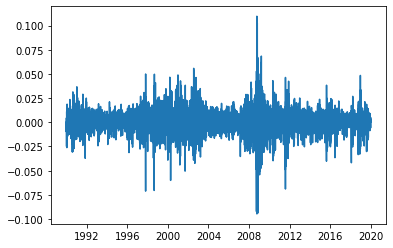

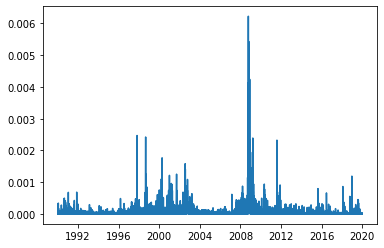

Open     High     Low    Close  AdjustedClose      Volume  \
Date                                                                      
2008-10-13 912.750 1006.930 912.750 1003.350       1003.350  7263370000   

            Timestep  OrdinaryReturn  LogReturn  ReturnDiff  
Date                                                         
2008-10-13      4736           0.116      0.110       0.006

Open     High     Low    Close  AdjustedClose      Volume  \
Date                                                                      
2008-10-13 912.750 1006.930 912.750 1003.350       1003.350  7263370000   
2008-10-15 994.600  994.600 903.990  907.840        907.840  6542330000   

            Timestep  OrdinaryReturn  LogReturn  ReturnDiff  
Date                                                         
2008-10-13      4736           0.116      0.110       0.006  
2008-10-15      4738          -0.090     -0.095       0.004

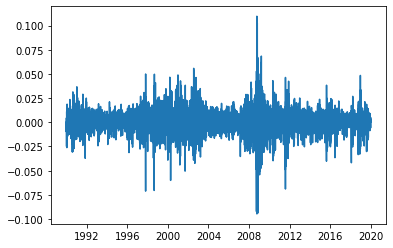

In [6]:
#Plot the logarithmic return

#Plot the ordinary "arithmetic" return
sp500.OrdinaryReturn.fillna(0, inplace=True)
sp500.LogReturn.fillna(0, inplace=True)

plt.plot(sp500.OrdinaryReturn)
plt.show()

#Plot the logarithmic return
plt.plot(sp500.LogReturn)
plt.show()

#Plot difference in returns
plt.plot(sp500.ReturnDiff)
plt.show()

plt.plot(sp500.LogReturn)
display(sp500[sp500.LogReturn==sp500.LogReturn.max()])

#Crisis period
sp500[(sp500.LogReturn==sp500.LogReturn.max()) |
      (sp500.LogReturn==sp500.LogReturn.min())]


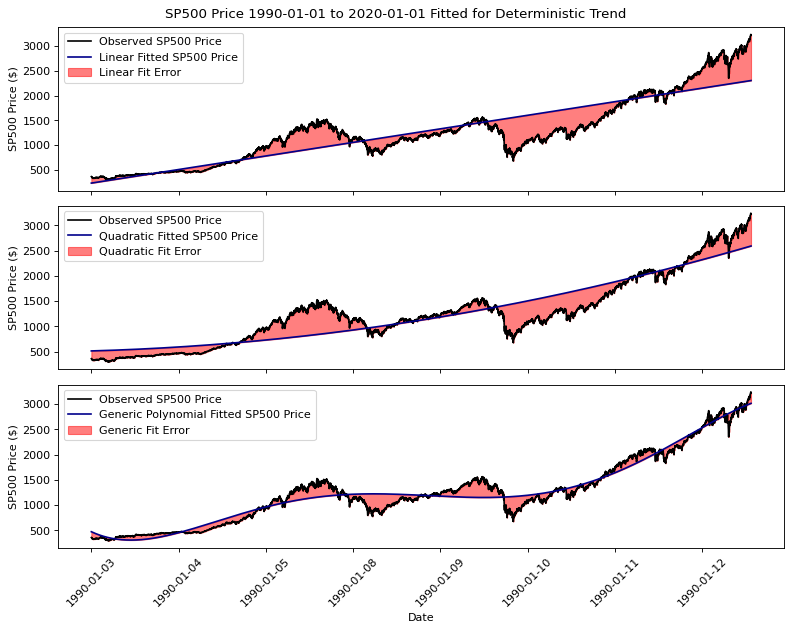

In [7]:
#fitted polynomials with different orders (linear, quad, any up to 5)
lin_model = np.poly1d(np.polyfit(sp500.Timestep, sp500.AdjustedClose, 1))
quad_model = np.poly1d(np.polyfit(sp500.Timestep, sp500.AdjustedClose, 2))
poly_model = np.poly1d(np.polyfit(sp500.Timestep, sp500.AdjustedClose, 5))

#Plot each fitted polynomial model
# noinspection PyTypeChecker
f, (ax1, ax2, ax3) = plt.subplots(3,
                                  1,
                                  sharey=False,
                                  sharex=True,
                                  figsize=(10,8),
                                  dpi=80)

#Linear Reg plot
ax1.plot(sp500.Timestep,
         sp500.AdjustedClose,
         color='black',
         label='Observed SP500 Price')
ax1.plot(sp500.Timestep,
         lin_model(sp500.Timestep),
         color='darkblue',
         label='Linear Fitted SP500 Price')
ax1.fill_between(sp500.Timestep, 
                 sp500.AdjustedClose,
                 lin_model(sp500.Timestep), 
                 color='r',
                 alpha=0.5,
                 label='Linear Fit Error')
ax1.set_xticklabels(sp500.index.strftime(date_format="%Y-%m-%d"))
ax1.set_ylabel("SP500 Price ($)")
ax1.legend()

#Quadratic Plot
ax2.plot(sp500.Timestep, 
         sp500.AdjustedClose, 
         color='black', 
         label='Observed SP500 Price')
ax2.plot(sp500.Timestep,
         quad_model(sp500.Timestep),
         color='darkblue', 
         label='Quadratic Fitted SP500 Price')
ax2.fill_between(sp500.Timestep, 
                 sp500.AdjustedClose,
                 quad_model(sp500.Timestep), 
                 color='r',
                 alpha=0.5,
                 label='Quadratic Fit Error')
ax2.set_ylabel("SP500 Price ($)")
ax2.legend()

#Generic Polynomial Plot
ax3.plot(sp500.Timestep,
         sp500.AdjustedClose, 
         color='black',
         label='Observed SP500 Price')
ax3.plot(sp500.Timestep, 
         poly_model(sp500.Timestep),
         color='darkblue',
         label='Generic Polynomial Fitted SP500 Price')
ax3.fill_between(sp500.Timestep, 
                 sp500.AdjustedClose,
                 poly_model(sp500.Timestep), 
                 color='r',
                 alpha=0.5,
                 label='Generic Fit Error')
ax3.set_ylabel("SP500 Price ($)")
ax3.legend()

#General plot formatting
plt.xlabel("Date")
plt.ylabel("SP500 Price ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.suptitle("SP500 Price {} to {} Fitted for Deterministic Trend".format(
             DATA_START,
             DATA_END)
            )
plt.subplots_adjust(top=0.95)
plt.show()

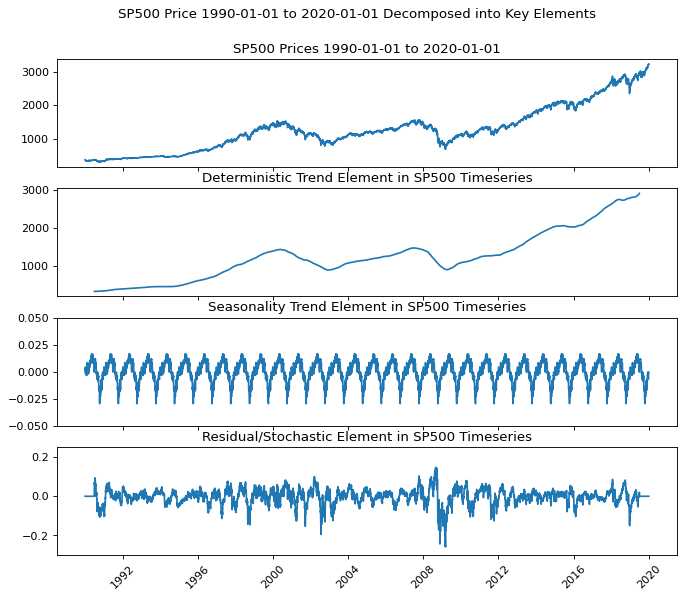

In [8]:
# Research how trend formed and units for seasonality and residual
result = seasonal_decompose(sp500.AdjustedClose,
                            model='multiplicative',
                            period=252)

# Plot each fitted polynomial model
# noinspection PyTypeChecker
_, (ax1, ax2, ax3, ax4) = plt.subplots(4,
                                       1, 
                                       sharey=False,
                                       sharex=True,
                                       figsize=(10,8),
                                       dpi=80)

ax1.plot(sp500.index, sp500.AdjustedClose)
ax1.set_title("SP500 Prices {} to {}".format(DATA_START, DATA_END))

ax2.plot(sp500.index, result.trend)
ax2.set_title("Deterministic Trend Element in SP500 Timeseries")

#1 normalized. Adjust to be 0 normalized
ax3.plot(sp500.index, result.seasonal.subtract(1))
ax3.set_title("Seasonality Trend Element in SP500 Timeseries")
ax3.set_ylim((-0.05, 0.05))

#1 normalized. Adjust to be 0 normalized and fill missing values where no noise present
ax4.plot(sp500.index, result.resid.subtract(1).fillna(0))
ax4.set_title("Residual/Stochastic Element in SP500 Timeseries")
ax4.set_ylim((-0.3, 0.25))

plt.suptitle("SP500 Price {} to {} Decomposed into Key Elements".format(
             DATA_START,
             DATA_END)
            )
plt.subplots_adjust(top=0.9)
plt.xticks(rotation=45)
plt.show()

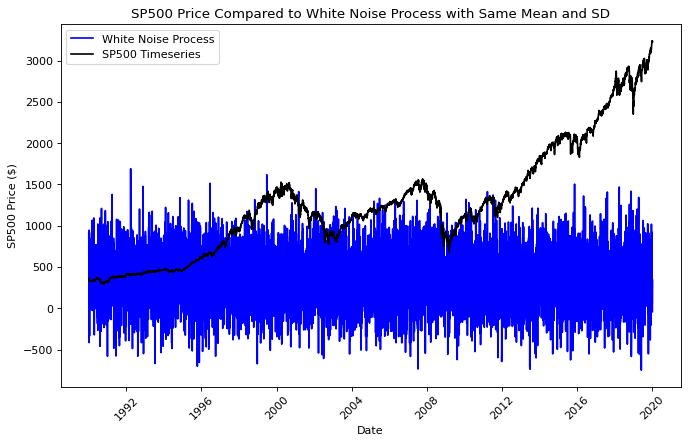

In [9]:
### Obs vs WN Graphical comparison
figure(figsize=(10, 6), dpi=80)
mean = sp500.AdjustedClose.iloc[0]
std = sp500.AdjustedClose.std()/2
num_samples = sp500.shape[0]
samples = np.random.normal(mean, 
                           std, 
                           size=num_samples)
plt.plot(sp500.index, samples, color='b', label='White Noise Process')
plt.plot(sp500.index, sp500.AdjustedClose, color='black', label='SP500 Timeseries')
plt.xlabel('Date')
plt.xticks(rotation='45')
plt.ylabel('SP500 Price ($)')
plt.title('SP500 Price Compared to White Noise Process with Same Mean and SD')
plt.legend(loc='upper left')
plt.show()

In [10]:
###Reasearch how trend formed and units for seasonality and residual
result = seasonal_decompose(sp500.LogReturn.fillna(0).abs().add(1),
                            model='multiplicative',
                            period=252)
#Plot each fitted polynomial model
# noinspection PyTypeChecker
_, (ax1, ax2, ax3, ax4) = plt.subplots(4,
                                       1,
                                       sharey=False,
                                       sharex=True,
                                       figsize=(10,8),
                                       dpi=80)

ax1.plot(sp500.index, sp500.LogReturn.fillna(0).add(1))
ax1.set_title("SP500 Log Return {} to {}".format(DATA_START, DATA_END))

ax2.plot(sp500.index, result.trend)
ax2.set_title("Deterministic Trend Element in SP500 LnReturn Timeseries")

# 1 normalized. Adjust to be 0 normalized
ax3.plot(sp500.index, result.seasonal.subtract(1))
ax3.set_title("Seasonality Trend Element in SP500 LnReturn Timeseries")
ax3.set_ylim((-0.03, 0.03))

# 1 normalized. Adjust to be 0 normalized and fill missing values where no noise present
ax4.plot(sp500.index, result.resid.subtract(1).fillna(0))
ax4.set_title("Residual/Stochastic Element in SP500 LnReturn Timeseries")
ax4.set_ylim((0, 0.1))

plt.suptitle("SP500 Log Return {} to {} Decomposed into Key Elements".format(
             DATA_START,
             DATA_END)
            )
plt.subplots_adjust(top=0.9)
plt.xticks(rotation=45)
plt.show()

In [11]:
###LB and BW White noise tests
lags = [1, 2, 5, 10, 20, 50]
results = []

for lag in lags:
    test = sm.stats.acorr_ljungbox(sp500.AdjustedClose.values, 
                                   lags=lag, 
                                   return_df=True,
                                  boxpierce=True)
    results.append(
        {
        'Lag':lag,
        "BoxPieceStat":test.bp_stat.iloc[0],
        "BoxPieceProb":test.bp_pvalue.iloc[0],
        "LjungBoxStat":test.lb_stat.iloc[0],
        "LjungBoxProb":test.lb_pvalue.iloc[0]
            
        }
    )

pd.DataFrame(results)

# Does the residual contain a unit root?
result = adfuller(result.resid.fillna(0))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.977597
p-value: 0.001532
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


## Moving Average Analysis

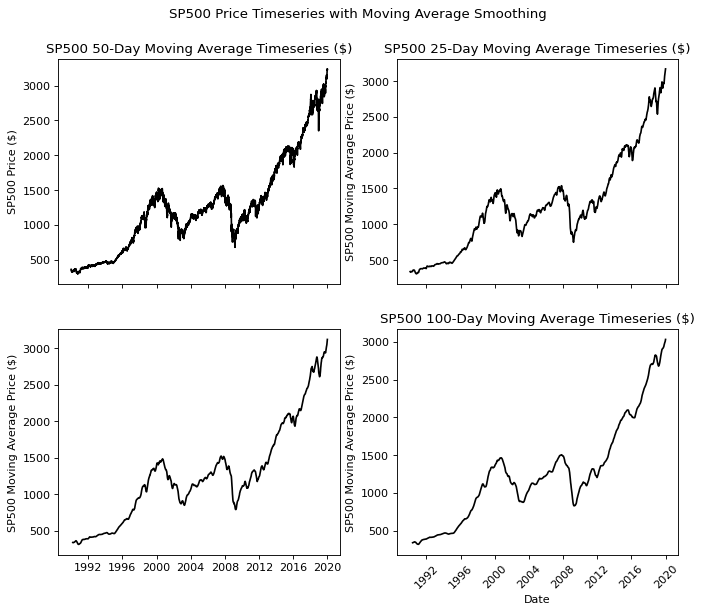

In [12]:
rolling_mean_25 = sp500['AdjustedClose'].rolling(25).mean()
rolling_mean_50 = sp500['AdjustedClose'].rolling(50).mean()
rolling_mean_100 = sp500['AdjustedClose'].rolling(100).mean()

# noinspection PyTypeChecker
f, ax = plt.subplots(2,
                     2, 
                     sharey=False,
                     sharex=True,
                     figsize=(10,8),
                     dpi=80)

plt.xlabel("Date")

ax[0,0].plot(sp500.AdjustedClose, color='black')
ax[0,0].set_title('Original $SP500 Timeseries ($)')
ax[0,0].set_ylabel("SP500 Price ($)")

ax[0,1].plot(rolling_mean_25, color='black')
ax[0,1].set_title('SP500 25-Day Moving Average Timeseries ($)')
ax[0,1].set_ylabel("SP500 Moving Average Price ($)")

ax[1,0].plot(rolling_mean_50, color='black')
ax[0,0].set_title('SP500 50-Day Moving Average Timeseries ($)')
ax[1,0].set_ylabel("SP500 Moving Average Price ($)")

ax[1,1].plot(rolling_mean_100, color='black')
ax[1,1].set_title('SP500 100-Day Moving Average Timeseries ($)')
ax[1,1].set_ylabel("SP500 Moving Average Price ($)")


plt.xticks(rotation='45')
plt.suptitle("SP500 Price Timeseries with Moving Average Smoothing".format(
             DATA_START,
             DATA_END)
            )
plt.subplots_adjust(top=0.9)
plt.show()

### AR Processes

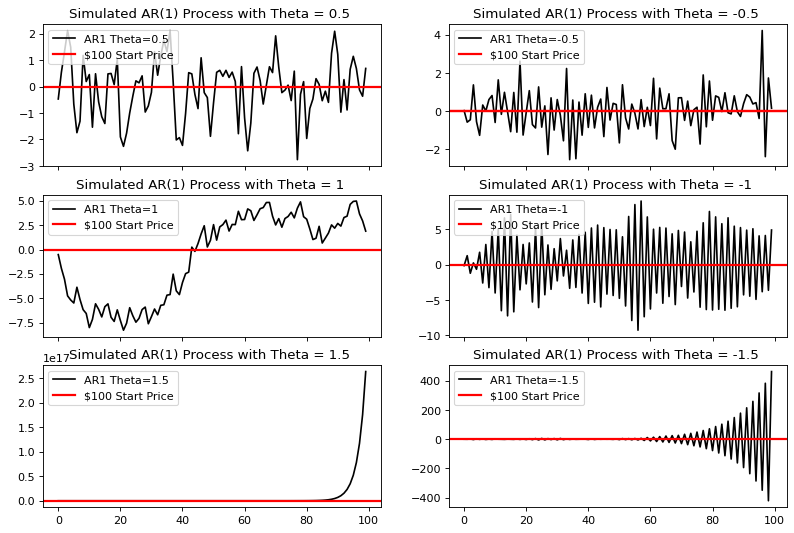

In [13]:
# noinspection PyTypeChecker
_, ax = plt.subplots(3,
                     2, 
                     sharey=False,
                     sharex=True,
                     figsize=(12,8),
                     dpi=80)
base = 0
ax[0,0].plot(simulate_ar1_process(theta=0.5,
                                  base=base),
             color='black',
             label='AR1 Theta=0.5')
ax[0,0].axhline(y=base, 
                linewidth=2,
                color='r',
                label='$100 Start Price')
ax[0,0].set_title("Simulated AR(1) Process with Theta = 0.5 ")
ax[0,0].legend(loc='upper left')

ax[0,1].plot(simulate_ar1_process(theta=-0.5,
                                  base=base),
             color='black',
             label='AR1 Theta=-0.5')
ax[0,1].axhline(y=base,
                linewidth=2,
                color='r')
ax[0,1].axhline(y=base,
                linewidth=2,
                color='r',
                label='$100 Start Price')
ax[0,1].set_title("Simulated AR(1) Process with Theta = -0.5 ")
ax[0,1].legend(loc='upper left')

ax[1,0].plot(simulate_ar1_process(theta=1,
                                  base=base),
             color='black',
             label='AR1 Theta=1')
ax[1,0].axhline(y=base, 
                linewidth=2,
                color='r',
                label='$100 Start Price')
ax[1,0].set_title("Simulated AR(1) Process with Theta = 1 ")
ax[1,0].legend(loc='upper left')

ax[1,1].plot(simulate_ar1_process(theta=-1,
                                  base=base),
             color='black',
             label='AR1 Theta=-1')
ax[1,1].axhline(y=base, 
                linewidth=2,
                color='r',
                label='$100 Start Price')
ax[1,1].set_title("Simulated AR(1) Process with Theta = -1 ")
ax[1,1].legend(loc='upper left')

ax[2,0].plot(simulate_ar1_process(theta=1.5,
                                  base=base),
             color='black',
             label='AR1 Theta=1.5')
ax[2,0].axhline(y=base, 
                linewidth=2,
                color='r',
                label='$100 Start Price')
ax[2,0].set_title("Simulated AR(1) Process with Theta = 1.5 ")
ax[2,0].legend(loc='upper left')

ax[2,1].plot(simulate_ar1_process(theta=-1.1,
                                  base=base),
             color='black',
             label='AR1 Theta=-1.5')
ax[2,1].axhline(y=base, 
                linewidth=2,
                color='r',
                label='$100 Start Price')
ax[2,1].set_title("Simulated AR(1) Process with Theta = -1.5 ")
ax[2,1].legend(loc='upper left')
plt.show()

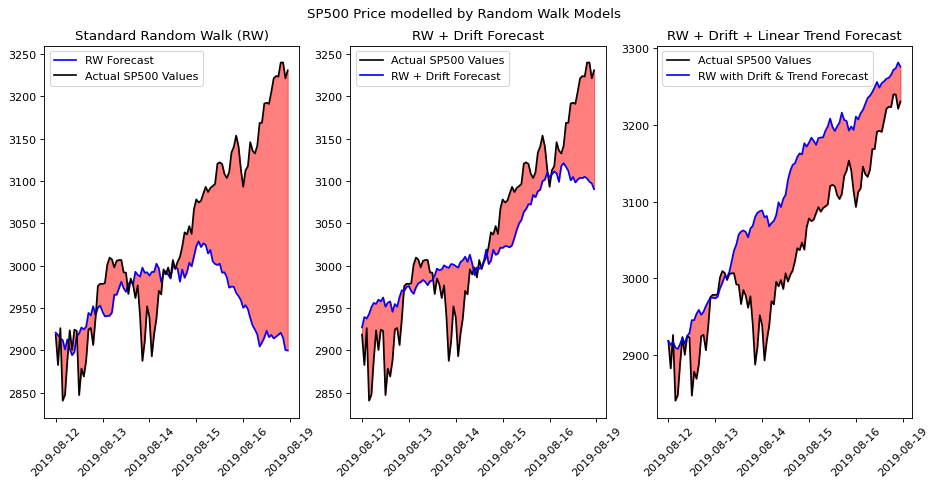

In [14]:
### Define a simple random walk model (1 lag, theta = 1, with/out drift, gauss errors)
rw_forecast = []
rw_drift_forecast = []
rw_det_forecast = []

# Random walk with no drift or det trend
starting_value = sp500.tail(100)['AdjustedClose'].iloc[0]
for i in range(0,100):
    error = np.random.normal(loc=0,
                             scale=sp500.AdjustedClose.std()*0.01,
                             size=None)
    starting_value += error
    rw_forecast.append(starting_value)
    

# RW with drift term
starting_value = sp500.tail(100)['AdjustedClose'].iloc[0]
for i in range(0,100):
    error = np.random.normal(loc=0,
                             scale=sp500.AdjustedClose.std()*0.01,
                             size=None)
    starting_value += (error + lin_model[0]/100) 
    rw_drift_forecast.append(starting_value)
    
# RW with deterministic trend (scaled back to 1 normalization)
starting_value = sp500.tail(100)['AdjustedClose'].iloc[0]
for i in range(0,100):
    error = np.random.normal(loc=0,
                             scale=sp500.AdjustedClose.std()*0.01,
                             size=None)
    starting_value += (error + + lin_model[0]/100 + lin_model[1]/100*i) 
    rw_det_forecast.append(starting_value)
    
# Plot the RW models with varying model specs
# noinspection PyTypeChecker
f, (ax0, ax1, ax2) = plt.subplots(1,
                                  3, 
                                  sharey=False,
                                  sharex=True,
                                  figsize=(14,6),
                                  dpi=80)

# Plot the standard RW model
ax0.plot(rw_forecast,
         color='blue',
         label = 'RW Forecast')

ax0.plot(sp500.tail(100)['AdjustedClose'].values, 
         color='black',
         label='Actual SP500 Values')
ax0.legend()
ax0.set_xticklabels(
    sp500.tail(100).index.strftime(
    date_format="%Y-%m-%d"),
    rotation=45
                   )

ax0.fill_between(list(range(0, len(rw_drift_forecast))),
                 sp500.tail(100)['AdjustedClose'].values,
                 rw_forecast, 
                 color='r',
                 alpha=0.5,
                 label='Random W/ Forecast Error')

ax0.set_title("Standard Random Walk (RW)")

# Plot RW with drift
ax1.plot(sp500.tail(100)['AdjustedClose'].values, 
         color='black',
         label='Actual SP500 Values')

ax1.plot(rw_drift_forecast, 
         color='blue',
         label='RW + Drift Forecast'
        )
ax1.legend()
ax1.fill_between(list(range(0, len(rw_drift_forecast))),
                 sp500.tail(100)['AdjustedClose'].values,
                 rw_drift_forecast, 
                 color='r',
                 alpha=0.5,
                 label='RW + Drift Forecast Error')

ax1.set_xticklabels(
    sp500.tail(100).index.strftime(
    date_format="%Y-%m-%d"),
    rotation=45
                   )
ax1.set_title("RW + Drift Forecast")

# Plot RW with drift and time trend
ax2.plot(sp500.tail(100)['AdjustedClose'].values, 
         color='black',
         label='Actual SP500 Values')

ax2.plot(rw_det_forecast, 
         color='blue',
         label='RW with Drift & Trend Forecast'
        )
ax2.legend()
ax2.fill_between(list(range(0, len(rw_det_forecast))),
                 sp500.tail(100)['AdjustedClose'].values,
                 rw_det_forecast, 
                 color='r',
                 alpha=0.5,
                 label='RW + Drift + Linear Trend Forecast Error')

ax2.set_xticklabels(
    sp500.tail(100).index.strftime(
    date_format="%Y-%m-%d"),
    rotation=45    )
ax2.set_title("RW + Drift + Linear Trend Forecast")

plt.suptitle("SP500 Price modelled by Random Walk Models".format(
             DATA_START,
             DATA_END)
            )

plt.subplots_adjust(top=0.9)
plt.show()


In [15]:
## Create a table counting number of obs per sample period and check total 

### Create label for subperiod 
sample_categories = ["pre-crisis", 
                     "crisis",
                     "post-crisis"]
sp500['SamplePeriod'] = np.where(sp500.index < pd.to_datetime("8/8/2007"),
                                 'pre-crisis',
                                 np.where(sp500.index < pd.to_datetime("3/10/2010"), 
                                          'crisis', 
                                          'post-crisis')
                                )

sample_obs_count = sp500.groupby('SamplePeriod').AdjustedClose.count().reset_index()
sample_obs_count.columns = ['SamplePeriod',
                            'NumberObservations']

# Sort samples based on chronological cat order rather than alphabetical 
sample_obs_count['SamplePeriod'] = pd.Categorical(sample_obs_count['SamplePeriod'],
                                                  sample_categories)
sample_obs_count.sort_values("SamplePeriod", inplace=True)

# Group by sample and count the number obs 
sample_obs_count.set_index('SamplePeriod',
                           inplace=True)

# Check that the total obs across all samples is all obs in dataset (no lost obs)
assert sample_obs_count.NumberObservations.sum() == sp500.shape[0], "Missing Observations"
sample_obs_count

NumberObservations
SamplePeriod                    
pre-crisis                  4437
crisis                       651
post-crisis                 2471

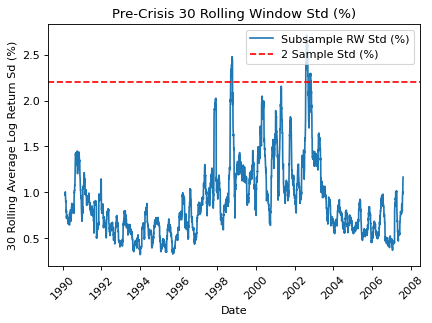

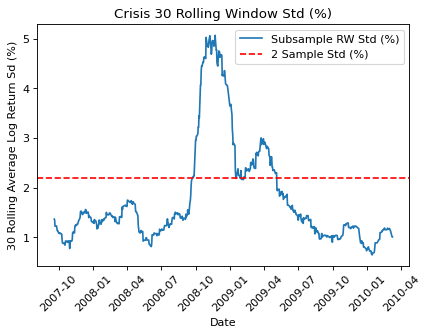

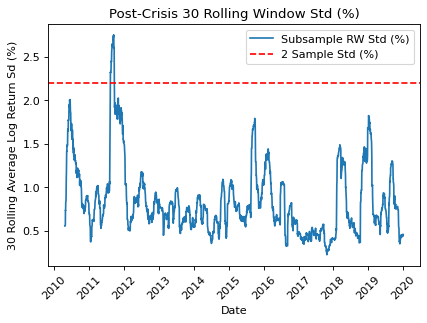

In [16]:
### Per sample SP500 return volatility plots
window_size = 30

for category in sample_categories:  
    subsample = sp500[sp500.SamplePeriod == category].copy()
    rolling_mean = subsample['LogReturn'].rolling(window_size).mean().multiply(100)
    rolling_std = subsample['LogReturn'].rolling(window_size).std().multiply(100)
    
    # Plot the rolling std for window 
    figure(figsize=(6, 4), dpi=80)
    plt.plot(rolling_std, 
             label='Subsample RW Std (%)')

    # Top line for 2* subsample std as percentage 
    plt.axhline(sp500.LogReturn.std()*100*2, 
                color="r", 
                linestyle="--",
                label='2 Sample Std (%)')

    # Place a legend on plot 
    plt.legend(loc='upper right')

    # Plot formatting title/axes etc. 
    plt.ylabel("{} Rolling Average Log Return Sd (%)".format(window_size))
    plt.xlabel("Date")
    plt.xticks(rotation=45)
    plt.title("{} {} Rolling Window Std (%)".format(category.title(),
                                                    window_size))
    plt.show()
    
    # Some useful information 
    

In [17]:
# Summary statistics for each period

results = []
for category in sample_categories:  
    subsample = sp500[sp500.SamplePeriod == category].copy()
    rolling_std = subsample['LogReturn'].rolling(window_size).std().multiply(100)
    
    summary_stats = {
        "Period": category.title(),
        "N": subsample.shape[0],
        "Mean Return": subsample.LogReturn.mean().round(4)*100,
        
        "Median Return": subsample.LogReturn.median().round(4)*100,
        
        "Return Range": (subsample.LogReturn.min().round(3)*100, 
                         subsample.LogReturn.max().round(2)*100),
        
        "Mean Return Std": subsample.LogReturn.std().round(2)*100,
                
        "Max {}d Rolling Std".format(window_size): rolling_std.max().round(1),
        
        "Min {}d Rolling Std".format(window_size): rolling_std.min().round(1),
    }
    results.append(summary_stats)

results = pd.DataFrame(results)
results.set_index('Period')

N  Mean Return  Median Return  Return Range  Mean Return Std  \
Period                                                                         
Pre-Crisis   4437        0.030          0.050   (-7.1, 6.0)            1.000   
Crisis        651       -0.040          0.090  (-9.5, 11.0)            2.000   
Post-Crisis  2471        0.040          0.060   (-6.9, 5.0)            1.000   

             Max 30d Rolling Std  Min 30d Rolling Std  
Period                                                 
Pre-Crisis                 2.700                0.300  
Crisis                     5.100                0.600  
Post-Crisis                2.700                0.200

In [18]:
summary_stats_table = []

# Generate results for full sample 
all_sample_stats = generate_full_stats(sp500, 'LogReturn')
all_sample_stats['Sample'] = 'All'
all_sample_stats = all_sample_stats.pivot(index='Sample',
                                          columns='Stat',
                                          values = 'Value')
all_sample_stats.reset_index(inplace=True)
summary_stats_table.append(all_sample_stats)

# Repeat for each subsample 
for category in sample_categories:  
    sub_sample = sp500[sp500.SamplePeriod == category].copy()
    sub_sample_stats = generate_full_stats(sub_sample, 'LogReturn')
    sub_sample_stats["Sample"] = category.title()
    sub_sample_stats = sub_sample_stats.pivot(
        index='Sample',
        columns='Stat',
        values = 'Value')
    sub_sample_stats.reset_index(inplace=True)
    summary_stats_table.append(sub_sample_stats)

# Tidy and standardise final table for paper
summary_stats_table = pd.concat(summary_stats_table)
summary_stats_table.set_index('Sample', inplace=True, drop=True)
summary_stats_table = summary_stats_table[SUMMARY_STATS_TABLE_COLUMN_ORDER]
summary_stats_table = summary_stats_table.round(4)
summary_stats_table['N'] = summary_stats_table.N.astype(int)
summary_stats_table

Stat            N    Min  Q-25%  Median   Mean  Q-75%   Max   Std   Skew  \
Sample                                                                     
All          7559 -0.095 -0.004   0.001  0.000  0.005 0.110 0.011 -0.267   
Pre-Crisis   4437 -0.071 -0.005   0.001  0.000  0.005 0.056 0.010 -0.120   
Crisis        651 -0.095 -0.009   0.001 -0.000  0.008 0.110 0.020 -0.145   
Post-Crisis  2471 -0.069 -0.003   0.001  0.000  0.005 0.048 0.009 -0.489   

Stat         Kurtosis  
Sample                 
All             8.865  
Pre-Crisis      3.928  
Crisis          5.172  
Post-Crisis     4.693

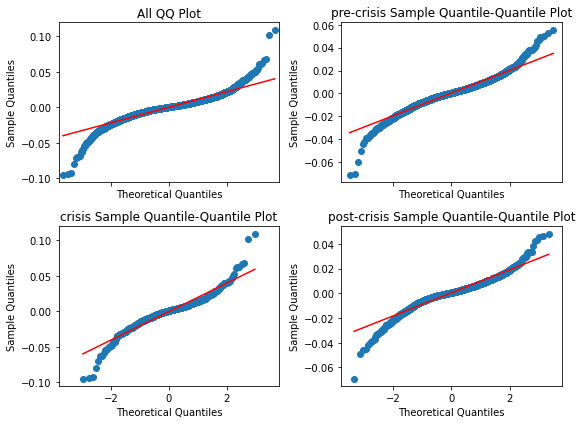

In [19]:
# noinspection PyTypeChecker
fig, axes = plt.subplots(ncols=2,
                         nrows=2,
                         sharex=True,
                         figsize=(8,6))

plot_categories = ['All'] + sample_categories
for k, ax in zip(plot_categories, np.ravel(axes)):
    if k == 'All':
        sm.qqplot(sp500.LogReturn, line='s', ax=ax)
        ax.set_title(f'{k} QQ Plot')
    else:
        sub_sample = sp500[sp500.SamplePeriod == k].copy()
        sm.qqplot(sub_sample.LogReturn, line='s', ax=ax)
        ax.set_title(f'{k} Sample Quantile-Quantile Plot')
        
plt.tight_layout()

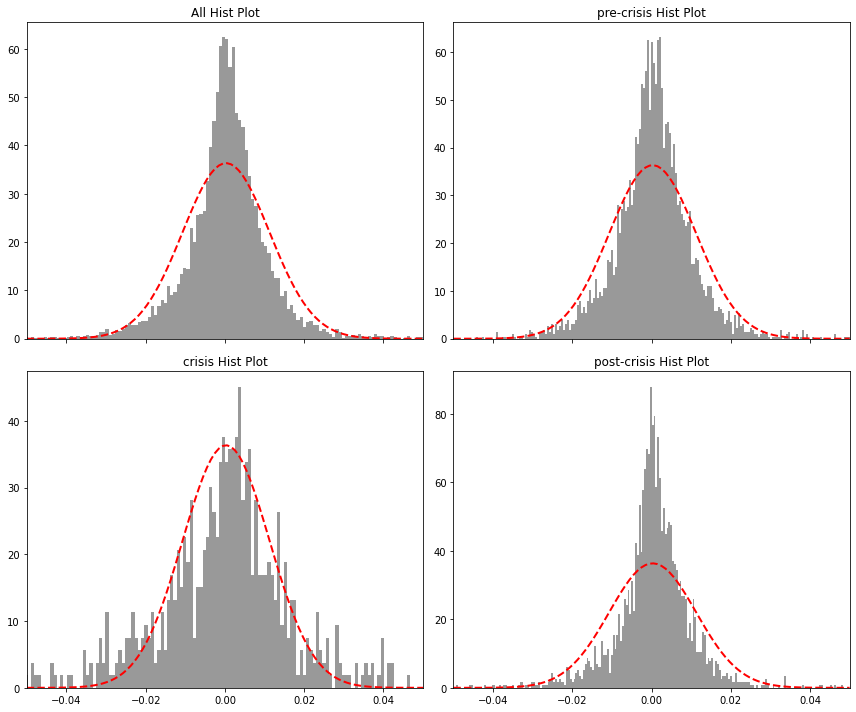

In [20]:
## Hist Plots 
# noinspection PyTypeChecker
fig, axes = plt.subplots(ncols=2,
                         nrows=2,
                         sharex=True,
                         figsize=(12, 10))
x_min, x_max = -0.05, 0.05
alpha = 0.4
bins = 250

for k, ax in zip(plot_categories, np.ravel(axes)):
    if k == 'All':
        ax.hist(sp500.LogReturn, 
                density=True, 
                bins=bins,
                alpha=alpha,
                color='black')
        ax.set_xlim(x_min, x_max)

        # Plot the hit on top
        mu, std = stats.norm.fit(sp500.LogReturn) 
        x = np.linspace(x_min, x_max, 100)
        p = stats.norm.pdf(x, mu, std)
        ax.plot(x, p, 'k', linewidth=2, color='red', linestyle='--')
        ax.set_title(f'{k} Hist Plot')
        
    else:
        subsample = sp500[sp500.SamplePeriod == k].copy()
        ax.hist(subsample.LogReturn, 
                alpha=alpha, 
                density=True,
                color='black', 
                bins=bins)
        ax.set_xlim(x_min, x_max)

        #Plot the hit on top
        mu, std = stats.norm.fit(sp500.LogReturn) 
        x = np.linspace(x_min, x_max, 100)
        p = stats.norm.pdf(x, mu, std)
        ax.plot(x, p, 'k', linewidth=2, color='red', linestyle="--")
        ax.set_title(f'{k} Hist Plot')
        
        
plt.tight_layout()


In [21]:
## Sample test table 
sample_stat_test_table = run_sample_stat_tests(sp500, "LogReturn")
sample_stat_test_table['Result'] = np.where(sample_stat_test_table.P < 0.05,
                                            "Reject Null",
                                            "Accept Null")
sample_stat_test_table.round(1)

Test     Stat     P  \
0           Adjusted-DF  -15.500 0.000   
1          Ljung-Box-20   21.500 0.000   
2         Shapiro-Wilks    0.900 0.000   
3  D'Agostino-K-squared 1320.700 0.000   
4        Anscombe-Glynn   35.100 0.000   

                                       Null       Result  
0                 Series contains Unit Root  Reject Null  
1                     Series is White Noise  Reject Null  
2             Series is Normal Distribution  Reject Null  
3  Series contains Normal Kurtosis and Skew  Reject Null  
4                        True Kurtosis is 3  Reject Null

## Modelling

In [22]:
# Drop the first row to standardise datasets (1-lag used by realized (intra-day) vol calc)
prices = sp500.AdjustedClose.values[1:]
returns = sp500.LogReturn.fillna(0).multiply(100).values[1:]
realized_vol = sp500.LogReturn.fillna(0).multiply(100).rolling(3).std().fillna(0).values[1:]
time_index = sp500.index.values[1:]

# Subset training and test sets
# 1008 = 4 * 252 = approx 4 years in trading days
n = len(prices)
n_test = 1008
n_train = n - n_test

prices_train = prices[:n_train-1]
prices_test = prices[n_train-1:n]

returns_train = returns[:n_train-1]
returns_test = returns[n_train-1:n]

realized_vol_train = realized_vol[:n_train-1]
realized_vol_test = realized_vol[n_train-1:n]

time_index_train = time_index[:n_train-1]
time_index_test = time_index[n_train-1:n]

print(prices.shape,
      returns.shape,
      realized_vol.shape,
      returns_train.shape, 
      returns_test.shape,
      realized_vol_train.shape,
      realized_vol_test.shape,
      time_index_train.shape,
      time_index_test.shape)


(7558,) (7558,) (7558,) (6549,) (1009,) (6549,) (1009,) (6549,) (1009,)


In [23]:
fig, axs = plt.subplots(2, 2, tight_layout=True)

axs[0, 0].plot(time_index_train, returns_train, color='black')
axs[0, 0].set_ylabel("Log Returns (%)")
axs[0, 0].set_title('In-Sample SP500 Log Returns')

axs[0, 1].plot(time_index_test, returns_test, color='black')
axs[0, 1].set_title('Out-Sample SP500 Log Returns')

axs[1, 0].plot(time_index_train, realized_vol_train)
axs[1, 0].set_title('In-Sample Realized Volatility')
axs[1, 0].set_ylabel("Realized SP500 Volatility (%)")

axs[1, 1].plot(time_index_test, realized_vol_test,)
axs[1, 1].set_title('Out-Sample SP500 Realized Volatility')

for ax in axs.flat:
    ax.set(xlabel='Time')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.suptitle("Comparison of In-Sample vs. Out-Sample SP500 Returns and  Volatility")
plt.show()

## Conditional Mean Modelling 

#### ARMA choosing model spec - ACF and PCF plots

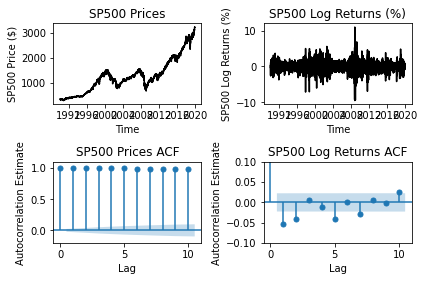

In [24]:
## ACF plot for prices and returns
fig, axes = plt.subplots(2,
                         2,
                         tight_layout=True)

#Prices ACF plot
axes[0, 0].plot(time_index, prices, color='black')
axes[0, 0].set_title('SP500 Prices')
axes[0, 0].set_xlabel("Time")
axes[0, 0].set_ylabel("SP500 Price ($)")

# Log Returns ACF plot
axes[0, 1].plot(time_index, returns, color='black')
axes[0, 1].set_title('SP500 Log Returns (%)')
axes[0, 1].set_xlabel("Time")
axes[0, 1].set_ylabel("SP500 Log Returns (%)")


plot_acf(prices, ax=axes[1, 0], lags=10)
axes[1, 0].set_ylim(-0.5, 1.05)
axes[1, 0].set_title('SP500 Prices ACF')
axes[1, 0].set_ylim(-0.2, 1.1)
axes[1, 0].set_xlabel("Lag")
axes[1, 0].set_ylabel("Autocorrelation Estimate")

plot_acf(returns, ax=axes[1, 1], lags=10)
axes[1, 1].set_ylim(-0.1, 0.1)
axes[1, 1].set_title('SP500 Log Returns ACF')
axes[1, 1].set_xlabel("Lag")
axes[1, 1].set_ylabel("Autocorrelation Estimate")

axes[0, 0].sharex(axes[0, 1])
axes[1, 0].sharex(axes[1, 1])


plt.show()

In [25]:
## PCF plot for prices and returns
_, axes = plt.subplots(2,
                       2,
                       tight_layout=True)

# Prices plot
axes[0, 0].plot(time_index, prices, color='black')
axes[0, 0].set_title('SP500 Prices')
axes[0, 0].set_xlabel("Time")
axes[0, 0].set_ylabel("SP500 Price ($)")

# Log Returns Plot
axes[0, 1].plot(time_index, returns, color='black')
axes[0, 1].set_title('SP500 Log Returns (%)')
axes[0, 1].set_xlabel("Time")
axes[0, 1].set_ylabel("SP500 Log Returns (%)")

# Prices PCF plot
plot_pacf(prices, ax=axes[1, 0], lags=10)
axes[1, 0].set_ylim(-0.5, 1.05)
axes[1, 0].set_title('SP500 Prices PCF')
axes[1, 0].set_ylim(-0.2, 1.1)
axes[1, 0].set_xlabel("Lag")
axes[1, 0].set_ylabel("Autocorrelation Estimate")

# Returns PCF fplot
plot_pacf(returns, ax=axes[1, 1], lags=10)
axes[1, 1].set_ylim(-0.1, 0.1)
axes[1, 1].set_title('SP500 Log Returns PCF')
axes[1, 1].set_xlabel("Lag")
axes[1, 1].set_ylabel("Autocorrelation Estimate")

axes[0, 0].sharex(axes[0, 1])
axes[1, 0].sharex(axes[1, 1])

plt.show()

#### Conditional Mean Modelling: choosing ARMA specification using modelling-as-anlysis/auto arima

In [26]:
auto_arima_price_model = pm.auto_arima(prices_train,
                                       seasonal=True,
                                       m=12)
print(auto_arima_price_model.summary())

auto_arima_return_model = pm.auto_arima(returns_train,
                                        seasonal=False)
print(auto_arima_return_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 6549
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 12)   Log Likelihood              -25913.117
Date:                             Sat, 13 Aug 2022   AIC                          51836.234
Time:                                     16:52:00   BIC                          51870.168
Sample:                                          0   HQIC                         51847.966
                                            - 6549                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0657      0.040      1.637      0.102      -0.013       0.144
ar.L1          0.7341      

### Train best ACF-PCF vs best searched model

In [27]:
# BEST fit an ARIMA model 
# fit ARMA(1,1) model
arma_returns_model_1_1 = ARIMA(returns_train, order=(1,0,1))
arma_returns_model_1_1 = arma_returns_model_1_1.fit()
print(arma_returns_model_1_1.summary())

# fit ARMA(2,1) model
arma_returns_model_2_1 = ARIMA(returns_train, order=(2,0,1))
arma_returns_model_2_1 = arma_returns_model_2_1.fit()
print(arma_returns_model_2_1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 6549
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -10108.985
Date:                Sat, 13 Aug 2022   AIC                          20225.970
Time:                        16:52:13   BIC                          20253.118
Sample:                             0   HQIC                         20235.356
                               - 6549                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0267      0.013      2.060      0.039       0.001       0.052
ar.L1          0.6531      0.050     12.954      0.000       0.554       0.752
ma.L1         -0.7097      0.046    -15.397      0.0

### One-step ahead ARMA forecast

In [28]:
# Copy the model so we don't update the original
arma_returns_model_1_1_copy = copy.deepcopy(arma_returns_model_1_1)

# Compute the first forecast based only on the training dataset
returns_test_pred = [arma_returns_model_1_1_copy.forecast()]

# Now step through the test observations:
# (a) add the new observation without refitting the model
# (b) produce a new forecast
for t in range(n_train, n):
    # Update the results by appending the next observation
    # Produce a forecast for t+1 based on data through t
    arma_returns_model_1_1_copy = arma_returns_model_1_1_copy.append(returns[t:t + 1], refit=False)
    returns_test_pred.append(arma_returns_model_1_1_copy.forecast())

# TODO: debug why forecast array seems to be compressed to 0.1 scale 
returns_test_pred = np.array(returns_test_pred)*10

In [29]:
plt.plot(time_index_test, returns_test, color='blue', label='SP500 Returns')
plt.plot(time_index_test, returns_test_pred, color='orange', label='ARMA(1,1) Forecasted Returns')
plt.title("True vs ARMA(1,1) Forecasted Out-Sample SP500 Log Returns")
plt.xticks(rotation=45)
plt.show()

### Conditional Volatility Estimation 

### Defining the Benchmark Garch Model

#### Choice 1: Determining whether GARCH needs normal, student t or skewed student t assumption (add to methodology)
* students T - deals with fat tails
* skew students T - deals with fat tails AND skew 
* Diff between normal and students T - if large, then fat tails important
* Diff between students T and skew T - if large, then skew important

In [30]:
res_normal = arch_model(returns, p=1, q=1).fit(disp="off")
res_t = arch_model(returns, p=1, q=1, dist="t").fit(disp="off")
res_skewt = arch_model(returns, p=1, q=1, dist="skewt").fit(disp="off")

lls = pd.Series(
    OrderedDict(
        (
            ("normal", res_normal.loglikelihood),
            ("t", res_t.loglikelihood),
            ("skewt", res_skewt.loglikelihood),
        )
    )
)
garch_dist_table = pd.DataFrame(
    OrderedDict(
        (
            ("normal", res_normal.params),
            ("t", res_t.params),
            ("skewt", res_skewt.params),
        )
    )
)

garch_dist_table = garch_dist_table.rename_axis('GARCH(1,1) Stat').reset_index()
garch_dist_table = garch_dist_table.append(
    {
    "GARCH(1,1) Stat": "LogL",
    "normal": round(res_normal.loglikelihood, 2),
    "t": round(res_t.loglikelihood, 2),
    "skewt": round(res_skewt.loglikelihood, 2)
    },
    ignore_index=True,
)

garch_dist_table = garch_dist_table.round(2)
garch_dist_table.fillna(0, inplace=True)
garch_dist_table.set_index('GARCH(1,1) Stat', inplace=True)
garch_dist_table.columns = ['Normal', 'Student-T', 'Skewed Student-T']
garch_dist_table

Normal  Student-T  Skewed Student-T
GARCH(1,1) Stat                                       
alpha[1]            0.100      0.090             0.090
beta[1]             0.890      0.910             0.910
eta                 0.000      0.000             6.480
lambda              0.000      0.000            -0.080
mu                  0.060      0.070             0.050
nu                  0.000      6.120             0.000
omega               0.020      0.010             0.010
LogL            -9872.400  -9685.340         -9672.370

In [31]:
garch_norm_residuals = pd.DataFrame()
garch_norm_residuals["Standardised Conditional Vol Residuals"] = res_normal.resid / res_normal.conditional_volatility
garch_norm_residuals["Standardised Unit Var Residuals"] = res_normal.resid / res_normal.resid.std()
subplot = garch_norm_residuals.plot(kind="kde", xlim=(-4, 4))

In [32]:
# Decision - use student t but now skewed student t 

### Choice 2: Choose orders for AR and MA GARCH processes using BIC

In [33]:
# choose best param set using BIC (MLE for opt each model, BIC for comparing)
#TODO: Look for a vectorised or at least optimised way of doing this (sklearn brute?)
print("SEARCHING FOR BEST GARCH MODEL SPECIFICATION OVER {} MODELS".format(NUMBER_GARCH_MODELS))

garch_model_results = []
for p in GARCH_P_RANGE:
    for q in GARCH_Q_RANGE:
        for o in GARCH_O_RANGE:
            for dist in GARCH_DISTRIBUTIONS:
                garch = arch_model(realized_vol,
                                   vol='GARCH',
                                   p=p,
                                   q=q,
                                   o=o,
                                   dist=dist,
                                   mean='constant').fit(disp='off')
                garch_model_results.append(
                    {
                        "AROrder(p)": p,
                        "MAOrder(q)": q,
                        "AsymOrder(o)":o,
                        "Dist": dist,
                        "AIC": garch.aic,
                        "BIC": garch.bic,
                        "LogL": garch.loglikelihood
                    }
                )

# Should be GARCH(1,4) with BIC=9355 if results/random seed hasn't changed
garch_model_results_proc = process_arch_results(garch_model_results)

print("COMPLETED SEARCH FOR BEST GARCH MODEL SPEC")

SEARCHING FOR BEST GARCH MODEL SPECIFICATION OVER 180 MODELS


/opt/anaconda3/envs/ars_dissertation_env/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/envs/ars_dissertation_env/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/envs/ars_dissertation_env/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


COMPLETED SEARCH FOR BEST GARCH MODEL SPEC


In [34]:
# However, 3 model specs rejected as only est fail converging var constraint
# # Failed to converge specs 1 3 0, 2 2 2 4 1 2
print("NUMBER OF MODEL SPECS RETURNED {}".format(garch_model_results_proc.shape[0]))

# Table for paper (best and worst ten)
garch_model_results_subset = garch_model_results_proc.head(5).append(garch_model_results_proc.tail(5))
garch_model_results_subset

NUMBER OF MODEL SPECS RETURNED 180


ModelID  AROrder(p)  MAOrder(q)  AsymOrder(o)   Dist         AIC  \
ModelRank                                                                     
0               38           1           4             0  skewt    9293.100   
1               41           1           4             1  skewt    9291.700   
2               29           1           3             0  skewt    9305.700   
3               32           1           3             1  skewt    9301.900   
4               89           2           4             2  skewt    9284.900   
175            118           3           3             0      t   22691.600   
176            173           4           4             0  skewt   23831.100   
177            103           3           1             1      t  102584.000   
178             26           1           2             2  skewt 1855022.800   
179             68           2           2             1  skewt 4077236.100   

                  BIC         LogL  
ModelRank                           
0            9355.400    -4637.500  
1            9361.000    -4635.900  
2            9361.100    -4644.800  
3            9364.300    -4641.900  
4            9368.100    -4630.400  
175         22754.000   -11336.800  
176         23914.300   -11903.600  
177        102639.500   -51284.000  
178       1855085.200  -927502.400  
179       4077298.400 -2038609.000

Best GARCH Params:
AR(p): 1
MA(q):4
Dist: skewt
                           Constant Mean - GARCH Model Results                           
Dep. Variable:                                 y   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:               -4637.53
Distribution:      Standardized Skew Student's t   AIC:                           9293.05
Method:                       Maximum Likelihood   BIC:                           9355.43
                                                   No. Observations:                 7558
Date:                           Sat, Aug 13 2022   Df Residuals:                     7557
Time:                                   16:54:16   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. I

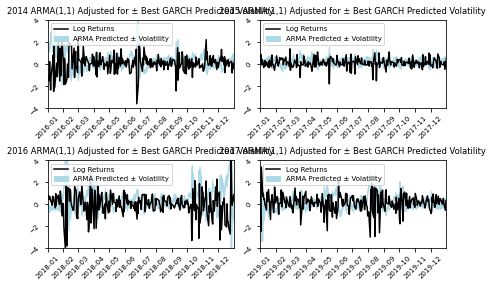

In [35]:
### Train Baseline GARCH model
# Sorted so 1st value is best model
best_AR_order = int(garch_model_results_proc["AROrder(p)"][0])
best_MA_order = int(garch_model_results_proc["MAOrder(q)"][0])
best_GARCH_dist = str(garch_model_results_proc['Dist'][0])

print("Best GARCH Params:\nAR(p): {}\nMA(q):{}\nDist: {}".format(best_AR_order,
                                                                 best_MA_order,
                                                                 best_GARCH_dist))

best_garch = arch_model(realized_vol,
                        vol='GARCH',
                        p=best_AR_order,
                        o=0,
                        q=best_MA_order,
                        dist=best_GARCH_dist).fit(disp='off')
print(best_garch.summary())

# Generate out-sample forecast using best GARCh model
realized_vol_pred_best_garch = best_garch.forecast(start=n_train).variance.iloc[-n_test - 1:]
realized_std_pred_best_garch = np.sqrt(realized_vol_pred_best_garch).fillna(0)

# calculate rmse for best garch model
rmse_best_garch = calc_rmse(realized_vol_test, realized_std_pred_best_garch)
print("Best GARCH RMSE: {}".format(rmse_best_garch))

# plot a nice vol plot for each test year
volatility_model_plot(returns_true=returns_test,
                      returns_pred=returns_test_pred,
                      vol_true=realized_vol_test,
                      vol_pred=realized_vol_pred_best_garch,
                      time_index=time_index_test,
                      vol_model_name = 'Best GARCH')

#### Question: Is GARCH(1, 4) sig different from GARCH(1,1)/
* Othwerwise put: does additional complexity of MA(4) process improve on GARCH(1,1)?
* No in both cases, RMSE are v diff (+0.1) and fails wilcox test

In [36]:
# paired t-test when GARCH(1,1) assumed to be normal
garch_1_1_normal = arch_model(realized_vol,
                              vol='GARCH',
                              p=1,
                              o=0,
                              q=1,
                              dist="normal").fit(disp='off')
print(garch_1_1_normal.summary())

# The variance component (not the mean) take the last 250 rows and divide by 100 (de-scale)
realized_vol_pred_garch_1_1_normal = garch_1_1_normal.forecast(start=n_train).variance.iloc[-n_test-1:]
realized_std_pred_garch_1_1_normal = np.sqrt(realized_vol_pred_garch_1_1_normal).fillna(0)

rmse_garch_1_1_normal= calc_rmse(realized_vol_test, realized_std_pred_garch_1_1_normal)
print(rmse_garch_1_1_normal)

# Use wilcox non-param approach because vol dist unlikely to be normal in some cases (add test)
res = wilcoxon(x=realized_std_pred_garch_1_1_normal,
               y=realized_std_pred_best_garch,
               alternative='two-sided')
print(res.statistic, res.pvalue)

# paired t-test when GARCH(1,4) assumed to be skewt
garch_1_1_normal = arch_model(realized_vol,
                              vol='GARCH',
                              p=1,
                              o=0,
                              q=1,
                              dist="skewt").fit(disp='off')

# the variance component (not the mean) take the last 250 rows and divide by 100 (de-scale)
realized_vol_pred_garch_1_1_skew = garch_1_1_normal.forecast(start=n_train).variance.iloc[-n_test-1:]
realized_std_pred_garch_1_1_skew = np.sqrt(realized_vol_pred_garch_1_1_skew).fillna(0)

rmse_garch_1_1_skew = calc_rmse(realized_vol_test, realized_std_pred_garch_1_1_skew)
print(rmse_garch_1_1_skew)

# Use wilcox non-param approach because vol dist unlikely to be normal in some cases (add test)
res = wilcoxon(x=realized_std_pred_garch_1_1_skew,
               y=realized_std_pred_best_garch,
               alternative='two-sided')
print(res.statistic, res.pvalue)

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5111.59
Distribution:                  Normal   AIC:                           10231.2
Method:            Maximum Likelihood   BIC:                           10258.9
                                        No. Observations:                 7558
Date:                Sat, Aug 13 2022   Df Residuals:                     7557
Time:                        16:54:17   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.5854  9.968e-03     58.722      0.000 [  0.566,  0.60

### ML Alternatives to Benchmark GARCH (1,4)
* SVR
    * Linear Kernel
    * Radial Kernel
    * Polynomial Kernel
* NN
    * Standard NN
    * Deep NN

### Build two-feature ML dataset
* ML models will not automatically square previous returns to create squared returns var
* Therefore, we need to make new featureset with realized vol and squared returns lag as vector

In [37]:
# obtain independent var realized vol and (squared) historical returns
realized_vol = pd.DataFrame(realized_vol)
realized_vol.reset_index(drop=True, inplace=True)

# shift returns and square
squared_returns = pd.DataFrame(np.roll(returns, +1) ** 2)
squared_returns.reset_index(drop=True, inplace=True)

# create one dataframe with both variables
ml_model_dataset = pd.concat([realized_vol, squared_returns],
                             axis=1,
                             ignore_index=True)

# drop the first row as this is nan due to realized returns calc
ml_model_data = ml_model_dataset.reset_index()
ml_model_data.drop('index', axis=1, inplace=True)

# subset datasets
ml_model_train = ml_model_data[:n_train-1]
ml_model_test = ml_model_data[n_train-1:n]

# shape check should be: (7558, 2) (6549, 2) (1009, 2)
print(ml_model_data.shape,
      ml_model_train.shape,
      ml_model_test.shape)
ml_model_dataset.head()

(7558, 2) (6549, 2) (1009, 2)


0     1
0 0.000 0.087
1 0.444 0.067
2 0.388 0.748
3 0.795 0.961
4 0.891 0.203

### SVM Conditional Volatility Models

In [ ]:
# Train linear kernel:
# determine best linear svr model by tuning hyper params

# SVC hyper param space
svc_param_grid = {
    'C' : [0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'gamma' : ('auto','scale'),
    'kernel': ['linear',
               'rbf',
               'poly',
               'sigmoid']
}

from sklearn.model_selection import cross_val_score
svr_lin_model = RandomizedSearchCV(SVR(),
                                   svc_param_grid,
                                   random_state=RANDOM_STATE,
                                   scoring='r2',
                                   cv=3)

# fit best linear svr model
svr_lin_model.fit(ml_model_train,
                  realized_vol_train)

svr_results_table = pd.DataFrame(svr_lin_model.cv_results_)

svr_results_table

In [ ]:
###
def process_gridsearch_results(model):
    gridsearch_results = pd.DataFrame(model.cv_results_)

    ## Fix issues where some test scores come out as negative (sklearn doc says use abs values)
    gridsearch_results['mean_test_score'] = gridsearch_results.mean_test_score.abs()

    # second issue is R2 scores can suffer from overflow where % applied 2x effectively making it 100*100
    # Notice this does not change the order (rank) of any models - best (worst) is still best (worst)
    gridsearch_results['mean_test_score_x'] = np.where(gridsearch_results.mean_test_score > 1000,
                                                     gridsearch_results.mean_test_score/10000,
                                                     np.where(gridsearch_results.mean_test_score > 1,
                                                              gridsearch_results.mean_test_score/10,
                                                              gridsearch_results.mean_test_score))
    gridsearch_results.sort_values('rank_test_score', inplace=True)

    return gridsearch_results

xx = process_gridsearch_results(svr_lin_model)

In [ ]:
# generate best linear svr model vol predictions
realized_vol_pred_svr_lin = svr_lin_model.predict(ml_model_test)

# Calculate RMSE for best linear SVR model vs known volatility
rmse_svr_lin = calc_rmse(realized_vol_test, realized_vol_pred_svr_lin)
print('The RMSE value of SVR with Linear Kernel is {:.6f}'.format(rmse_svr_lin))

volatility_model_plot(returns_true=returns_test,
                      returns_pred=returns_test_pred,
                      vol_true=realized_vol_test,
                      vol_pred=realized_vol_pred_svr_lin,
                      time_index=time_index_test,
                      vol_model_name = 'Linear SVR')

In [ ]:
# SVR-GARCH application using the RBF kernel (param grid is the same)

# determine best radial svr model by tuning hyper params
svr_rbf_kernel = SVR(kernel='rbf') 
svr_rbf_model = RandomizedSearchCV(svr_rbf_kernel,
                                   svc_param_grid,
                                   random_state=RANDOM_STATE) 

# fit best radial svr model 
svr_rbf_model.fit(ml_model_train, realized_vol_train)

# generate best linear svr model vol predictions
realized_vol_pred_svr_rbf = svr_rbf_model.predict(ml_model_test)

# Calculate RMSE for best linear SVR model vs known volatility
rmse_svr_rbf = calc_rmse(realized_vol_test, realized_vol_pred_svr_rbf)
print('The RMSE value of SVR with RBF Kernel is {:.6f}'.format(rmse_svr_rbf))

volatility_model_plot(returns_true=returns_test,
                      returns_pred=returns_test_pred,
                      vol_true=realized_vol_test,
                      vol_pred=realized_vol_pred_svr_rbf,
                      time_index=time_index_test,
                      vol_model_name = 'Radial Basis SVR')

In [ ]:
# Polynomial kernel 

# Choose best params for SVR with polynomial kernel 
svr_poly_kernel = SVR(kernel='poly', degree=2) 
svr_poly_model = RandomizedSearchCV(svr_poly_kernel,
                                    svc_param_grid,
                                    random_state=RANDOM_STATE)

# fit best svr with polynomial kernel 
svr_poly_model.fit(ml_model_train[0:4000], realized_vol_train[0:4000])

# generate best linear svr model vol predictions
realized_vol_pred_svr_poly = svr_poly_model.predict(ml_model_test)

# Calculate RMSE for best linear SVR model vs known volatility 
rmse_svr_poly = np.sqrt(mse(realized_vol_test, realized_vol_pred_svr_poly))
print('The RMSE value of SVR with Poly Kernel is {:.6f}'.format(rmse_svr_poly))

volatility_model_plot(returns_true=returns_test,
                      returns_pred=returns_test_pred,
                      vol_true=realized_vol_test,
                      vol_pred=realized_vol_pred_svr_poly,
                      time_index=time_index_test,
                      vol_model_name = 'Polynomial SVR')

### Neural Networks 
* Standard MLP
* DNN

In [ ]:
# Configure and tune 3 HL NN with various neurons (nodes) per HL
mlp_vol_model = MLPRegressor(learning_rate_init=LEARNING_RATE,
                             random_state=RANDOM_STATE)
mlp_vol_model = RandomizedSearchCV(mlp_vol_model, nn_param_grid)

# fit best MLP vol model
mlp_vol_model.fit(ml_model_train, realized_vol_train)

# generate best linear svr model vol predictions
realized_vol_pred_mlp = mlp_vol_model.predict(ml_model_test)

# Calculate RMSE for best linear SVR model vs known volatility
rmse_mlp = np.sqrt(mse(realized_vol_test, realized_vol_pred_mlp))
print('The RMSE value of SVR with Poly Kernel is {:.6f}'.format(rmse_mlp))

volatility_model_plot(returns_true=returns_test,
                      returns_pred=returns_test_pred,
                      vol_true=realized_vol_test,
                      vol_pred=realized_vol_pred_mlp, 
                      time_index=time_index_test,
                      vol_model_name = 'Standard MLP')

In [ ]:
# configure DNN structure by setting number layers and neurons
dnn_model = keras.Sequential(
                         [tf.keras.layers.Dense(256, activation="relu"),
                          tf.keras.layers.Dense(128, activation="relu"),
                          tf.keras.layers.Dense(1, activation="linear")
                         ]
            ) 

# Compile the NN by giving it a loss function and opt alg
dnn_model.compile(loss='mse',
                  optimizer='rmsprop') 

# decide the epochs and batch size 
dnn_predictions = []
dnn_rmse_values = []

# fit dnn model
for iteration, epoch, batch in zip(DNN_N_ITER,
                                   DNN_EPOCHS,
                                   DNN_BATCHES):

    # Fit this iteration of DNN
    dnn_model.fit(
        ml_model_train,
        realized_vol_train,
        batch_size=batch, 
        epochs=epoch,
        verbose=False) 

    # Generate predictions for this iteration of DNN + est this iteration's RMSE
    dnn_iter_predictions = dnn_model.predict(ml_model_test)
    dnn_iter_rmse = calc_rmse(realized_vol_test, realized_vol_pred_mlp)
    print('Per Iteration DNN RMSE_{}:{:.6f}'.format(iteration+1, dnn_iter_rmse))

    # Save predictions and rmse for this iter
    dnn_predictions.append(dnn_iter_predictions)
    dnn_rmse_values.append(dnn_iter_rmse)

# Find the best iteration with its corresponding prediction set and rmse
best_dnn_predictions = pd.DataFrame(dnn_predictions[dnn_rmse_values.index(min(dnn_rmse_values)
                                                                          )
                                    ])

rmse_dnn = calc_rmse(realized_vol_test,
                     best_dnn_predictions)
print('The Best DNN Model Generated RMSE Value: {:.6f}'.format(rmse_dnn))
      
volatility_model_plot(returns_true=returns_test,
                      returns_pred=returns_test_pred,
                      vol_true=realized_vol_test,
                      vol_pred=best_dnn_predictions, 
                      time_index=time_index_test,
                      vol_model_name = 'DNN')

### Vol Model Results

In [ ]:
vol_model_names = [
    "ARCH (5)", 
    "GARCH (2,1)",
    "GJR GARCH (1,1,1)",
    "SVR Linear",
    "SVR Radial",
    "SVR Polynomial",
    "Standard Neural Net",
    "DNN"
]

vol_model_rmse = [
    rmse_best_arch,
    rmse_best_garch,
    rmse_gjr_garch,
    rmse_svr_lin,
    rmse_svr_rbf,
    rmse_svr_poly,
    rmse_mlp,
    rmse_dnn
]

## Results table
vol_model_results_table = pd.DataFrame({"Volatility Model": vol_model_names,
                                        "RMSE": vol_model_rmse})
vol_model_results_table.set_index('Volatility Model')
vol_model_results_table['RMSE (%)'] = vol_model_results_table.RMSE.multiply(100).round(2)
vol_model_results_table

### Todo List 

#### Modelling TODO: 
* Put table for ARMA results (log lik, rmse, paired t-test diff between rmse) 
* Stat test for sig different between benchmark (arch) and each model - paired T-test/Db and Mar - add to table
* Total RMSE conditional mean + vol vs real data (add to table)
* Test residuals from all conditional vol models to check if WN (add test p stat to table)

* Feature weight importance for NN and SVR (graphing to avoid blackbox)
* Add regularisation to best ML 

#### housekeeping/bugs
* Finish methodology bits for NN and regularisation 
* Add section for regularisation 
* Finish writing up literature review 
* Tidy all tables/plots and put in diss 

#### Nice to have 
## To GARCH vs Best ML (don't repeat for all)
* Add HLOC range estimators (find paper for how to modify GARCH, use in SVM and NN)
* Add volume as estimator too does this improve? 
* Compare Best models over each period (keep sample period the same as/Table for each (pre, during, post-crisis)
